In [1]:
import numpy as np
import numba
from numba import cuda
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
#%matplotlib widget*
figsize=(8,4)

import rumdpy as rumd
import rumdpy as rp

In [2]:
print(numba.__version__)

0.55.1


In [3]:

def benchmark(nx, ny, nz, pb, tp, skin, gridsync=True, UtilizeNIII=True, steps=1000, cut=2.5, integrator='NVE'):

    compute_plan = {'pb':pb, 'tp':tp, 'skin':skin, 'UtilizeNIII':UtilizeNIII, 'gridsync':gridsync}
    
    # Generate numpy arrays for particle positions and simbox of a FCC lattice with a given density 
    positions, simbox_data = rp.generate_fcc_positions(nx=nx, ny=ny, nz=nz, rho=0.8442)
    N, D = positions.shape
    assert N==nx*ny*nz*4, f'Wrong number particles (FCC), {N} <> {nx*ny*nz*4}'
    assert D==3, f'Wrong dimension (FCC), {D} <> {3}'

    ### Make configuration. Could be read from file or generated from single convenience function, but this shows flexibility
    c1 = rp.Configuration(N, D, simbox_data)
    c1['r'] = positions
    c1['v'] = rp.generate_random_velocities(N, D, T=1.44)
    c1['m'] =  np.ones(N, dtype=np.float32)     # Set masses
    c1.ptype = np.zeros(N, dtype=np.int32)      # Set types
   
    # Make the pair potential. NOTE: params is a 2 dimensional numpy array of tuples
    params = np.zeros((1,1), dtype="f,f,f")
    params[0][0] = (4., -4., 2.5)
    print('Pairpotential paramaters:\n', params)
    LJ = rp.PairPotential(c1, rp.apply_shifted_force_cutoff(rp.LJ_12_6), params=params, max_num_nbs=1000, compute_plan=compute_plan)
    num_cscalars = 3
 
    
    # NOTE: following three objects are specific to system size and other parameters for technical reasons

    interactions = rp.make_interactions(c1, pair_potential = LJ, num_cscalars=num_cscalars, compute_plan=compute_plan, verbose=True,)

    step_nve = rumd.make_step_nve(c1, compute_plan=compute_plan, verbose=True, )
    step_nvt = rumd.make_step_nvt(c1, compute_plan=compute_plan, verbose=True, )
    
    integrate_nve = rumd.make_integrator(c1, step_nve, interactions, compute_plan=compute_plan, verbose=True) 
    integrate_nvt = rumd.make_integrator(c1, step_nvt, interactions, compute_plan=compute_plan, verbose=True)
   
    dt = np.float32(0.005)
    skin = np.float32(0.5)
    md_time_unit = 2.e-12
    print(f'dt = {dt} = {dt*md_time_unit*1e15} fs')

    c1.copy_to_device()           
    LJ.copy_to_device()
 
    interaction_params = (LJ.d_params, skin, LJ.nblist.d_nblist,  LJ.nblist.d_nbflag)
    integrator_params = (dt, )

    start = cuda.event()
    end = cuda.event()

 
    MATS = 50
    TPS = MATS*1.e6/N
       
    inner_steps = 1000
    test_steps = int(TPS*1)
    print('test_steps : ', test_steps)
    
    
    tps_max = 0.0
    skins = np.linspace(0.1, 1.4, 14)
    timings = np.zeros_like(skins)
    nblist_updates = np.zeros_like(skins)
    
    T = np.float32(0.7)
    tau=0.2
    omega2 = np.float32(4.0*np.pi*np.pi/tau/tau)
    degrees = N*D - D
    
    for i in range(len(skins)):
        c1.copy_to_device()
        LJ.copy_to_device()

        thermostat_state = np.zeros(2, dtype=np.float32)
        d_thermostat_state = cuda.to_device(thermostat_state)
        
        interaction_params = (LJ.d_params, np.float32(skins[i]), LJ.nblist.d_nblist, LJ.nblist.d_nbflag)
        nve_params = (dt, )
        nvt_params = (dt, T, omega2, degrees,  d_thermostat_state)
        start.record()
        if integrator=='NVE':
            integrate_nve(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data, interaction_params,
                        nve_params, test_steps)
        if integrator=='NVT':         
            integrate_nvt(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data, interaction_params,
                        nvt_params, test_steps)
        nbflag = LJ.nblist.d_nbflag.copy_to_host()
        end.record()
        end.synchronize()
        
        timings[i] = cuda.event_elapsed_time(start, end)
        tps = test_steps/timings[i]*1000    

        print(f'{i}, {skins[i]:.3f}, {tps:.3f}, nbflag:{nbflag}')
        if tps>tps_max:
            tps_max = tps
            skin = skins[i]
        nblist_updates[i] = nbflag[2]
        
    print('optimal skin:', skin)
    
    c1.copy_to_device()                
    LJ.copy_to_device()
    
    interaction_params = (LJ.d_params, np.float32(skin), LJ.nblist.d_nblist, LJ.nblist.d_nbflag)

    start.record()
  
    scalars_t = []
    tt = []
    for i in range(steps):
        if integrator=='NVE':
            integrate_nve(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data, interaction_params,
                        nve_params, inner_steps)
        if integrator=='NVT':         
            integrate_nvt(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data, interaction_params,
                        nvt_params, inner_steps)
        scalars_t.append(np.sum(c1.d_scalars.copy_to_host(), axis=0))
        tt.append(i*inner_steps*dt)
            
    end.record()
    end.synchronize()
    timing_numba = cuda.event_elapsed_time(start, end)
    nbflag = LJ.nblist.d_nbflag.copy_to_host()    
    tps = steps*inner_steps/timing_numba*1000
    ns_per_step = dt*md_time_unit*1e9

    print('\tsteps :', steps*inner_steps)
    print('\tnbflag : ', nbflag)
    print('\ttime :', timing_numba/1000, 's')
    print('\ttime/steps :', timing_numba/(steps*inner_steps)*1000, 'us')
    print('\tTPS : ', tps )
    print('\tMATS : ', steps*inner_steps*N/timing_numba*1000/1e6)
    print('\tns/day : ', tps*ns_per_step*3600*24 )
    print('\tms/year : ', tps*ns_per_step*3600*24*1e-6*365)
    print()
   
    df = pd.DataFrame(np.array(scalars_t), columns=c1.sid.keys())
    if UtilizeNIII:
        df['u'] *= 2
        df['w'] *= 2
        df['lap'] *= 2
    df['w'] *= 1/D/2
    df['t'] = np.array(tt)  
    
    rumd.plot_scalars(df, N, D, figsize=(15,4))
    
    return  skins, timings, nblist_updates

# N=256

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVE integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVT integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  195312


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (32) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 62804.629, nbflag:[    0     0 52671]
1, 0.200, 104088.889, nbflag:[    0     0 28355]
2, 0.300, 105510.999, nbflag:[    0     0 19105]
3, 0.400, 108869.862, nbflag:[    0     0 14222]
4, 0.500, 102034.861, nbflag:[    0     0 11157]
5, 0.600, 99502.573, nbflag:[   0    0 9072]
6, 0.700, 100326.904, nbflag:[   0    0 7534]
7, 0.800, 95903.013, nbflag:[   0    0 6343]
8, 0.900, 94066.389, nbflag:[   0    0 5388]
9, 1.000, 96541.058, nbflag:[   0    0 4607]
10, 1.100, 88604.654, nbflag:[   0    0 3974]
11, 1.200, 93005.747, nbflag:[   0    0 3420]
12, 1.300, 86921.087, nbflag:[   0    0 2980]
13, 1.400, 86232.629, nbflag:[   0    0 2585]
optimal skin: 0.4
	steps : 1000000
	nbflag :  [    0     0 72756]
	time : 9.8387919921875 s
	time/steps : 9.8387919921875 us
	TPS :  101638.49391206265
	MATS :  26.01945444148804
	ns/day :  87815.6567771892
	ms/year :  32.05271472367406



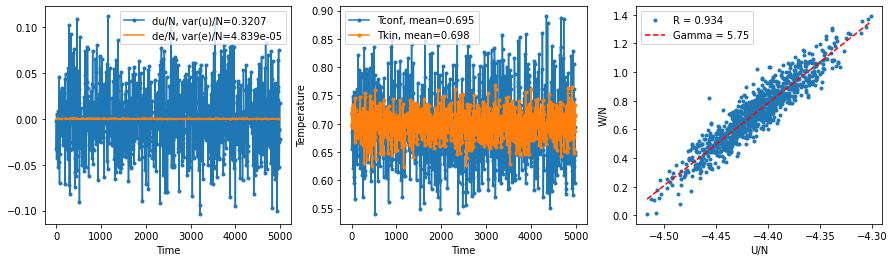

In [4]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=4, pb=8, tp=32, skin=0.4, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVE integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVT integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  195312


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (32) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 60262.074, nbflag:[    0     0 52706]
1, 0.200, 91948.144, nbflag:[    0     0 28364]
2, 0.300, 97963.127, nbflag:[    0     0 19096]
3, 0.400, 94205.804, nbflag:[    0     0 14232]
4, 0.500, 91991.367, nbflag:[    0     0 11180]
5, 0.600, 92445.363, nbflag:[   0    0 9084]
6, 0.700, 88659.280, nbflag:[   0    0 7531]
7, 0.800, 85718.808, nbflag:[   0    0 6358]
8, 0.900, 75090.012, nbflag:[   0    0 5408]
9, 1.000, 84910.140, nbflag:[   0    0 4619]
10, 1.100, 82960.119, nbflag:[   0    0 3981]
11, 1.200, 79540.433, nbflag:[   0    0 3425]
12, 1.300, 75946.046, nbflag:[   0    0 3005]
13, 1.400, 78798.939, nbflag:[   0    0 2576]
optimal skin: 0.3
	steps : 1000000
	nbflag :  [    0     0 97880]
	time : 10.980130859375 s
	time/steps : 10.980130859374999 us
	TPS :  91073.59582569866
	MATS :  23.31484053137886
	ns/day :  78687.58503459902
	ms/year :  28.72096853762864



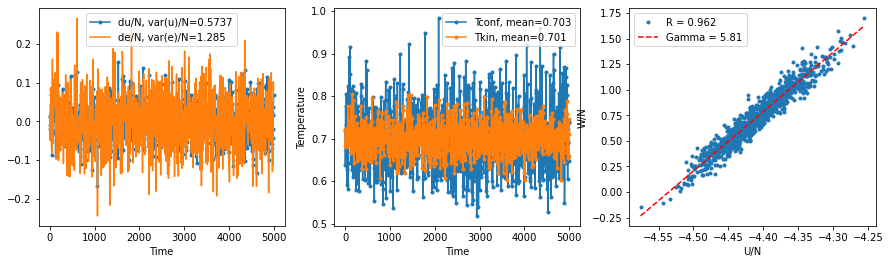

In [5]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=4, pb=8, tp=32, skin=0.4, UtilizeNIII=False, integrator='NVT')

# N=512

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 512 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 16384
Generating NVE integrator for 512 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 16384
Generating NVT integrator for 512 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  97656


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 40222.198, nbflag:[    0     0 27809]
1, 0.200, 76733.974, nbflag:[    0     0 14843]
2, 0.300, 78563.791, nbflag:[    0     0 10048]
3, 0.400, 79247.412, nbflag:[   0    0 7499]
4, 0.500, 76625.191, nbflag:[   0    0 5919]
5, 0.600, 77801.680, nbflag:[   0    0 4811]
6, 0.700, 75758.924, nbflag:[   0    0 4015]
7, 0.800, 74258.892, nbflag:[   0    0 3411]
8, 0.900, 72180.112, nbflag:[   0    0 2920]
9, 1.000, 72351.713, nbflag:[   0    0 2524]
10, 1.100, 68290.833, nbflag:[   0    0 2189]
11, 1.200, 64252.141, nbflag:[   0    0 1901]
12, 1.300, 66893.661, nbflag:[   0    0 1661]
13, 1.400, 61178.803, nbflag:[   0    0 1458]
optimal skin: 0.4
	steps : 1000000
	nbflag :  [    0     0 76745]
	time : 13.45008203125 s
	time/steps : 13.45008203125 us
	TPS :  74348.98892635704
	MATS :  38.0666823302948
	ns/day :  64237.524996551874
	ms/year :  23.446696623741435



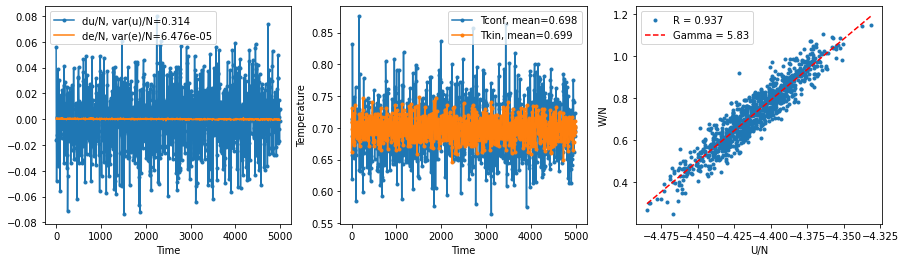

In [6]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=8, pb=8, tp=32, skin=0.4, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 512 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 8192
Generating NVE integrator for 512 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 8192
Generating NVT integrator for 512 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 8192
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  97656


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 36705.290, nbflag:[    0     0 27940]
1, 0.200, 70958.812, nbflag:[    0     0 14862]
2, 0.300, 70751.699, nbflag:[    0     0 10060]
3, 0.400, 72311.329, nbflag:[   0    0 7485]
4, 0.500, 72745.604, nbflag:[   0    0 5912]
5, 0.600, 74151.386, nbflag:[   0    0 4825]
6, 0.700, 72252.551, nbflag:[   0    0 4023]
7, 0.800, 73597.728, nbflag:[   0    0 3404]
8, 0.900, 76504.847, nbflag:[   0    0 2918]
9, 1.000, 74926.633, nbflag:[   0    0 2521]
10, 1.100, 70435.636, nbflag:[   0    0 2179]
11, 1.200, 63567.208, nbflag:[   0    0 1916]
12, 1.300, 69641.196, nbflag:[   0    0 1668]
13, 1.400, 64677.161, nbflag:[   0    0 1465]
optimal skin: 0.8999999999999999
	steps : 1000000
	nbflag :  [    0     0 29872]
	time : 14.450771484375 s
	time/steps : 14.450771484375 us
	TPS :  69200.45764208902
	MATS :  35.43063431274958
	ns/day :  59789.19406637225
	ms/year :  21.82305583422587



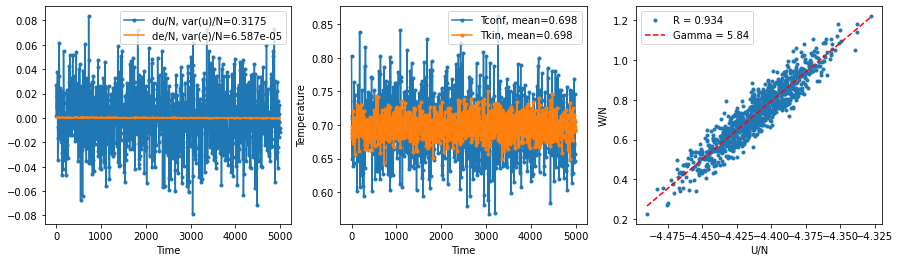

In [7]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=8, pb=8, tp=16, skin=0.4)

# N=1024

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
Generating NVE integrator for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
Generating NVT integrator for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  48828
0, 0.100, 20829.479, nbflag:[    0     0 14987]
1, 0.200, 53315.571, nbflag:[   0    0 7782]
2, 0.300, 55674.297, nbflag:[   0    0 5252]
3, 0.400, 57989.940, nbflag:[   0    0 3937]
4, 0.500, 56749.284, nbflag:[   0    0 3114]
5, 0.600, 55714.761, nbflag:[   0    0 2544]
6, 0.700, 55457.139, nbflag:[   0    0 2129]
7, 0.800, 53521.611, nbflag:[   0    0 1812]
8, 0.900, 51874.365, nbflag:[   0    0 1559]
9, 1.000, 51082.091, nbfla

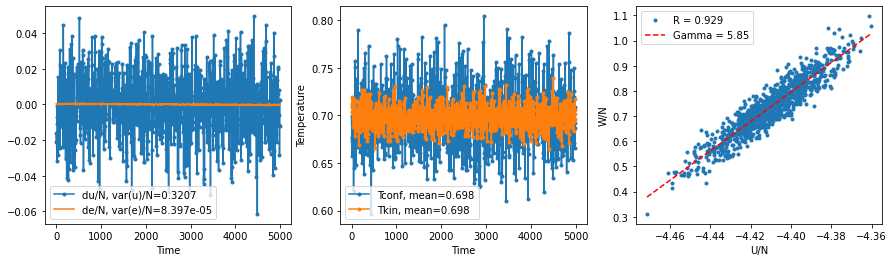

In [8]:
skins, timings, nblist_updates = benchmark(nx=4, ny=8, nz=8, pb=8, tp=16, skin=0.5, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
Generating NVE integrator for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
Generating NVT integrator for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  48828
0, 0.100, 23802.410, nbflag:[    0     0 15011]
1, 0.200, 45859.798, nbflag:[   0    0 7785]
2, 0.300, 52066.106, nbflag:[   0    0 5260]
3, 0.400, 51779.263, nbflag:[   0    0 3935]
4, 0.500, 47819.511, nbflag:[   0    0 3109]
5, 0.600, 53232.332, nbflag:[   0    0 2549]
6, 0.700, 48446.061, nbflag:[   0    0 2134]
7, 0.800, 52797.614, nbflag:[   0    0 1817]
8, 0.900, 48205.286, nbflag:[   0    0 1563]
9, 1.000, 48511.303, nbfla

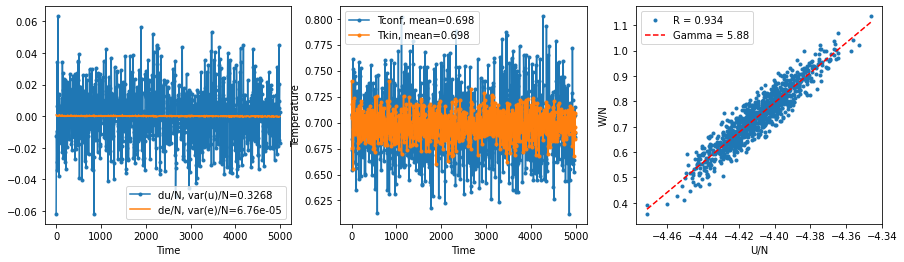

In [9]:
skins, timings, nblist_updates = benchmark(nx=4, ny=8, nz=8, pb=8, tp=16, skin=0.5)

# N=2048

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 2048 particles in 3 dimensions:
	pb: 16, tp:8, num_blocks:128
	Number (virtual) particles: 2048
	Number of threads 16384
Generating NVE integrator for 2048 particles in 3 dimensions:
	pb: 16, tp:8, num_blocks:128
	Number (virtual) particles: 2048
	Number of threads 16384
Generating NVT integrator for 2048 particles in 3 dimensions:
	pb: 16, tp:8, num_blocks:128
	Number (virtual) particles: 2048
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  24414
0, 0.100, 10329.807, nbflag:[   0    0 7925]
1, 0.200, 28233.324, nbflag:[   0    0 4044]
2, 0.300, 31184.540, nbflag:[   0    0 2737]
3, 0.400, 33033.810, nbflag:[   0    0 2047]
4, 0.500, 33013.678, nbflag:[   0    0 1624]
5, 0.600, 33956.226, nbflag:[   0    0 1331]
6, 0.700, 33807.257, nbflag:[   0    0 1120]
7, 0.800, 33415.291, nbflag:[  0   0 957]
8, 0.900, 32827.664, nbflag:[  0   0 827]
9, 1.000, 32659.243, nbflag:[  0   

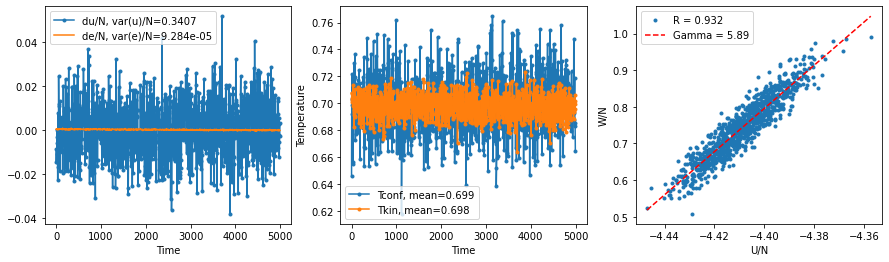

In [10]:
skins, timings, nblist_updates = benchmark(nx=8, ny=8, nz=8, pb=16, tp=8, skin=0.5)

# N=4096

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
Generating NVE integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
Generating NVT integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  12207
0, 0.100, 4908.687, nbflag:[   0    0 4060]
1, 0.200, 12377.317, nbflag:[   0    0 2081]
2, 0.300, 14729.385, nbflag:[   0    0 1427]
3, 0.400, 16296.749, nbflag:[   0    0 1070]
4, 0.500, 17219.125, nbflag:[  0   0 848]
5, 0.600, 17845.057, nbflag:[  0   0 695]
6, 0.700, 17849.395, nbflag:[  0   0 588]
7, 0.800, 17977.505, nbflag:[  0   0 502]
8, 0.900, 17835.515, nbflag:[  0   0 435]
9, 1.000, 17407.678, nbflag:[  0   0 382]
10,

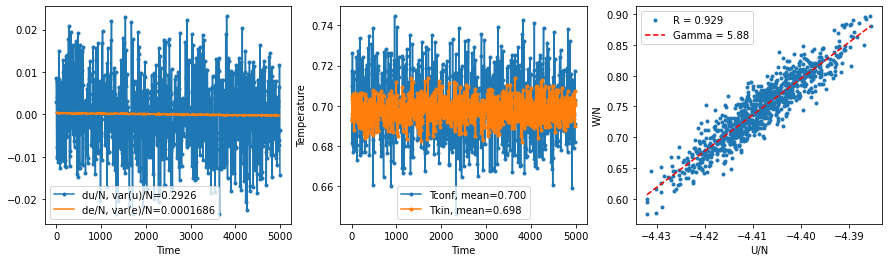

In [11]:
skins, timings, nblist_updates = benchmark(nx=8, ny=8, nz=16, pb=16, tp=4, skin=0.6)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
Generating NVE integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
Generating NVT integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  12207
0, 0.100, 4194.878, nbflag:[   0    0 4058]
1, 0.200, 11393.105, nbflag:[   0    0 2090]
2, 0.300, 13347.881, nbflag:[   0    0 1427]
3, 0.400, 14764.729, nbflag:[   0    0 1067]
4, 0.500, 15438.645, nbflag:[  0   0 847]
5, 0.600, 15860.653, nbflag:[  0   0 696]
6, 0.700, 15926.836, nbflag:[  0   0 588]
7, 0.800, 15813.850, nbflag:[  0   0 503]
8, 0.900, 15859.292, nbflag:[  0   0 438]
9, 1.000, 15619.686, nbflag:[  0   0 379]
10,

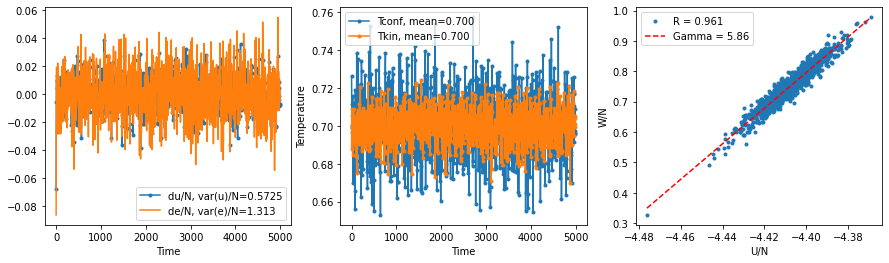

In [12]:
skins, timings, nblist_updates = benchmark(nx=8, ny=8, nz=16, pb=16, tp=4, skin=0.6, integrator='NVT')

# N=8192

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVE integrator for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVT integrator for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  6103
0, 0.100, 1837.627, nbflag:[   0    0 2038]
1, 0.200, 4148.772, nbflag:[   0    0 1071]
2, 0.300, 5328.577, nbflag:[  0   0 738]
3, 0.400, 6222.529, nbflag:[  0   0 554]
4, 0.500, 6861.325, nbflag:[  0   0 442]
5, 0.600, 7257.513, nbflag:[  0   0 364]
6, 0.700, 7480.149, nbflag:[  0   0 305]
7, 0.800, 7560.080, nbflag:[  0   0 263]
8, 0.900, 7558.859, nbflag:[  0   0 226]
9, 1.000, 7536.178, nbflag:[  0   0 199]
10, 1.100, 7354.364

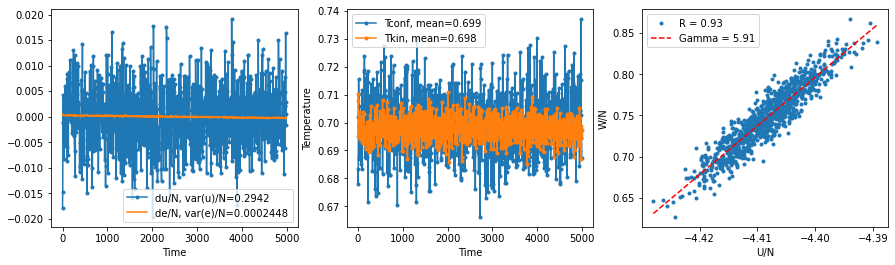

In [13]:
skins, timings, nblist_updates = benchmark(nx=8, ny=16, nz=16, pb=32, tp=2, skin=0.9)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVE integrator for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVT integrator for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  6103
0, 0.100, 1263.263, nbflag:[   0    0 2037]
1, 0.200, 2893.571, nbflag:[   0    0 1081]
2, 0.300, 3809.830, nbflag:[  0   0 738]
3, 0.400, 4431.774, nbflag:[  0   0 557]
4, 0.500, 4950.016, nbflag:[  0   0 442]
5, 0.600, 5309.608, nbflag:[  0   0 363]
6, 0.700, 5516.470, nbflag:[  0   0 306]
7, 0.800, 5638.456, nbflag:[  0   0 267]
8, 0.900, 5712.382, nbflag:[  0   0 229]
9, 1.000, 5698.837, nbflag:[  0   0 200]
10, 1.100, 5612.601

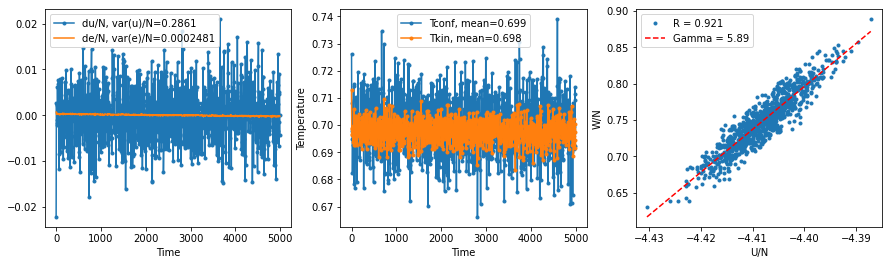

In [14]:
skins, timings, nblist_updates = benchmark(nx=8, ny=16, nz=16, pb=32, tp=2, skin=0.9, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 8192 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:128
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVE integrator for 8192 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:128
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVT integrator for 8192 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:128
	Number (virtual) particles: 8192
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  6103
0, 0.100, 1812.012, nbflag:[   0    0 2036]
1, 0.200, 4006.664, nbflag:[   0    0 1070]
2, 0.300, 5133.856, nbflag:[  0   0 736]
3, 0.400, 5950.664, nbflag:[  0   0 556]
4, 0.500, 6601.088, nbflag:[  0   0 442]
5, 0.600, 6986.407, nbflag:[  0   0 362]
6, 0.700, 7265.310, nbflag:[  0   0 308]
7, 0.800, 7389.276, nbflag:[  0   0 263]
8, 0.900, 7410.225, nbflag:[  0   0 228]
9, 1.000, 7435.996, nbflag:[  0   0 200]
10, 1.100, 7285.169

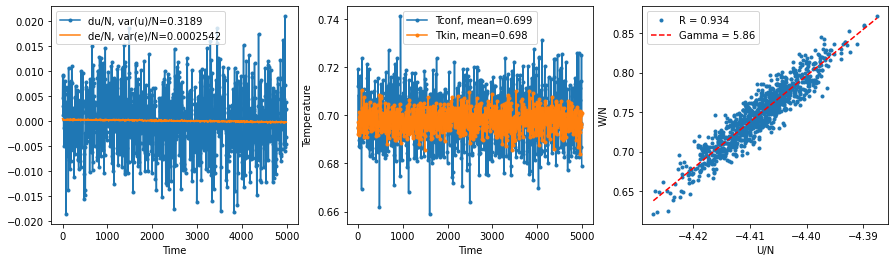

In [15]:
skins, timings, nblist_updates = benchmark(nx=8, ny=16, nz=16, pb=64, tp=2, skin=0.9)

# N=16384

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 524.145, nbflag:[   0    0 1019]
1, 0.200, 1119.342, nbflag:[  0   0 560]
2, 0.300, 1526.225, nbflag:[  0   0 382]
3, 0.400, 1864.959, nbflag:[  0   0 287]
4, 0.500, 2171.533, nbflag:[  0   0 228]
5, 0.600, 2397.381, nbflag:[  0   0 189]
6, 0.700, 2572.452, nbflag:[  0   0 160]
7, 0.800, 2704.781, nbflag:[  0   0 138]
8, 0.900, 2840.942, nbflag:[  0   0 120]
9, 1.000, 2936.201, nbflag:[  0   0 105]
10, 1.100, 2966.4

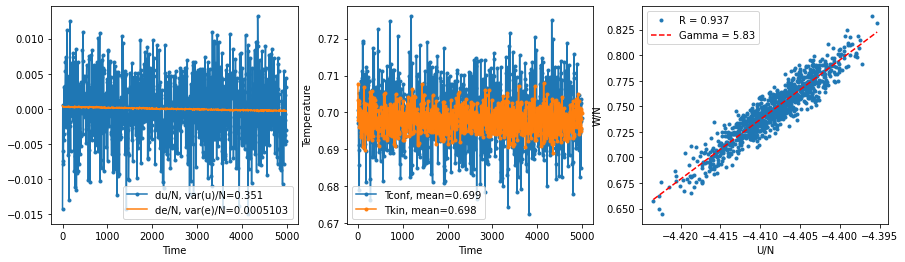

In [16]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=1, skin=1.0, gridsync=True, UtilizeNIII=True)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 520.644, nbflag:[   0    0 1021]
1, 0.200, 1055.223, nbflag:[  0   0 560]
2, 0.300, 1430.132, nbflag:[  0   0 381]
3, 0.400, 1751.878, nbflag:[  0   0 286]
4, 0.500, 2000.881, nbflag:[  0   0 229]
5, 0.600, 2209.615, nbflag:[  0   0 188]
6, 0.700, 2365.957, nbflag:[  0   0 159]
7, 0.800, 2494.779, nbflag:[  0   0 137]
8, 0.900, 2619.694, nbflag:[  0   0 118]
9, 1.000, 2675.555, nbflag:[  0   0 104]
10, 1.100, 2694.3

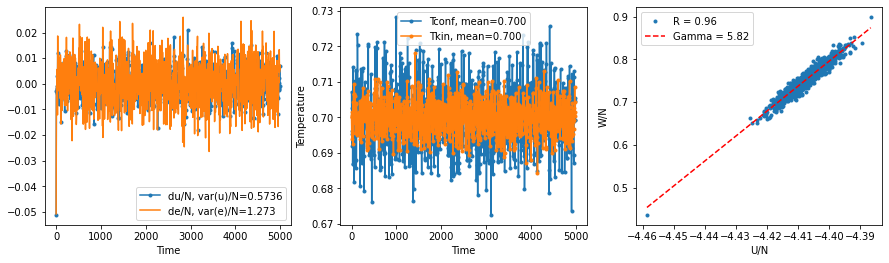

In [17]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=1, skin=1.0, gridsync=True, UtilizeNIII=True, integrator='NVT')

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 388.578, nbflag:[   0    0 1019]
1, 0.200, 762.299, nbflag:[  0   0 558]
2, 0.300, 1051.440, nbflag:[  0   0 382]
3, 0.400, 1309.796, nbflag:[  0   0 287]
4, 0.500, 1532.340, nbflag:[  0   0 228]
5, 0.600, 1706.182, nbflag:[  0   0 189]
6, 0.700, 1846.472, nbflag:[  0   0 160]
7, 0.800, 1957.763, nbflag:[  0   0 138]
8, 0.900, 2051.907, nbflag:[  0   0 119]
9, 1.000, 2096.458, nbflag:[  0   0 106]
10, 1.100, 2135.95

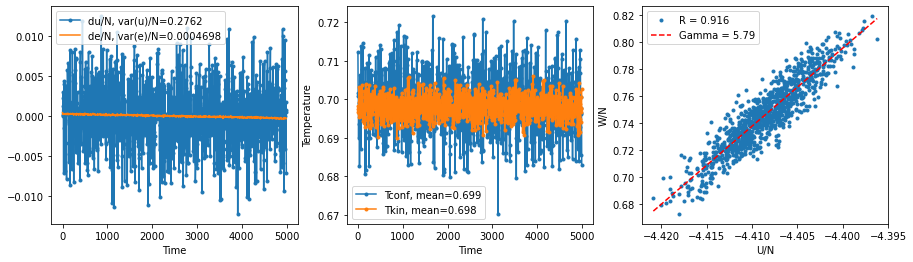

In [18]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=1, skin=1.0, gridsync=True, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 585.407, nbflag:[   0    0 1022]
1, 0.200, 1358.598, nbflag:[  0   0 564]
2, 0.300, 1854.685, nbflag:[  0   0 381]
3, 0.400, 2269.100, nbflag:[  0   0 289]
4, 0.500, 2643.549, nbflag:[  0   0 228]
5, 0.600, 2921.982, nbflag:[  0   0 190]
6, 0.700, 2938.320, nbflag:[  0   0 161]
7, 0.800, 2908.926, nbflag:[  0   0 138]
8, 0.900, 2926.343, nbflag:[  0   0 119]
9, 1.000, 2872.834, nbflag:[  0   0 105]
10, 1.100, 2770.1

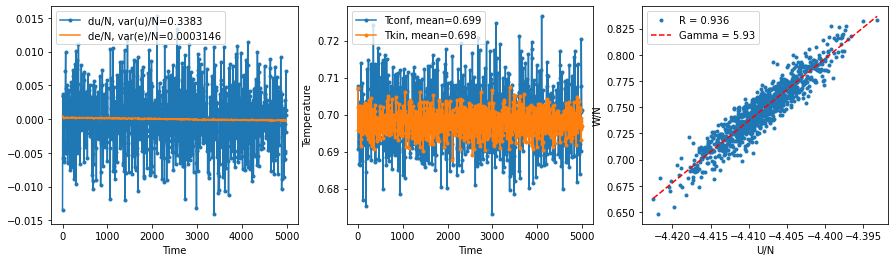

In [19]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=2, skin=1.0, gridsync=False, UtilizeNIII=True)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 613.942, nbflag:[   0    0 1026]
1, 0.200, 1241.290, nbflag:[  0   0 565]
2, 0.300, 1677.131, nbflag:[  0   0 384]
3, 0.400, 1700.291, nbflag:[  0   0 288]
4, 0.500, 1690.070, nbflag:[  0   0 231]
5, 0.600, 1729.067, nbflag:[  0   0 192]
6, 0.700, 1724.615, nbflag:[  0   0 161]
7, 0.800, 1687.971, nbflag:[  0   0 138]
8, 0.900, 1737.963, nbflag:[  0   0 119]
9, 1.000, 1750.232, nbflag:[  0   0 106]
10, 1.100, 1728.921, nbflag:[ 0  0 93]
11, 1.200, 1716.608, nbflag:[ 0  0 83]
12, 1.300, 1714.640, nbflag:[ 0  0 74]
13, 1.400, 1735.761, nbflag:[ 0  0 67]
optimal skin: 0.9999999999999999
	steps : 1000000
	nbflag :  [    0     0 34154]
	time : 594.460625 s
	time/steps : 594.4606249999999 us
	TPS :  1682.1972018752294
	MATS :  27.56111895552376
	ns/day :  1453.418349933766
	ms/year :  0.5304976977258246



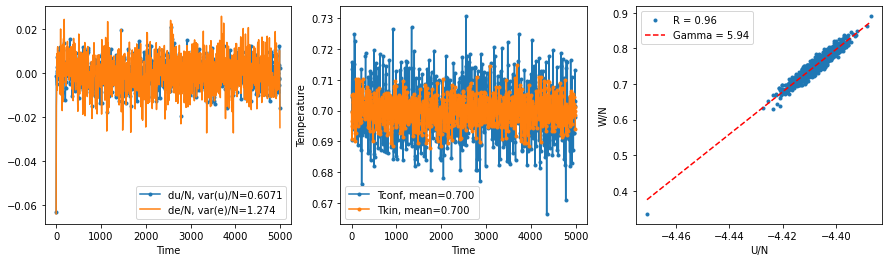

In [20]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=2, skin=1.0, gridsync=False, UtilizeNIII=True, integrator='NVT')

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 504.409, nbflag:[   0    0 1022]
1, 0.200, 1018.765, nbflag:[  0   0 564]
2, 0.300, 1411.018, nbflag:[  0   0 384]
3, 0.400, 1770.052, nbflag:[  0   0 287]
4, 0.500, 2064.494, nbflag:[  0   0 229]
5, 0.600, 2248.705, nbflag:[  0   0 190]
6, 0.700, 2455.684, nbflag:[  0   0 160]
7, 0.800, 2636.090, nbflag:[  0   0 137]
8, 0.900, 2747.114, nbflag:[  0   0 120]
9, 1.000, 2828.553, nbflag:[  0   0 106]
10, 1.100, 2871.0

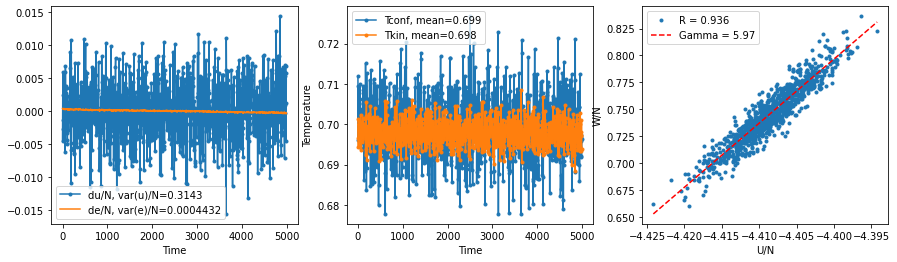

In [21]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=2, skin=1.0, gridsync=False, UtilizeNIII=False)

# N=32768

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVE integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVT integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  1525
0, 0.100, 170.865, nbflag:[  0   0 511]
1, 0.200, 345.384, nbflag:[  0   0 296]
2, 0.300, 504.706, nbflag:[  0   0 197]
3, 0.400, 633.783, nbflag:[  0   0 150]
4, 0.500, 762.105, nbflag:[  0   0 119]
5, 0.600, 867.490, nbflag:[ 0  0 99]
6, 0.700, 973.669, nbflag:[ 0  0 83]
7, 0.800, 1050.174, nbflag:[ 0  0 72]
8, 0.900, 1129.060, nbflag:[ 0  0 63]
9, 1.000, 1188.823, nbflag:[ 0  0 56]
10, 1.100, 1235.286, nbflag:[ 0  0 49]

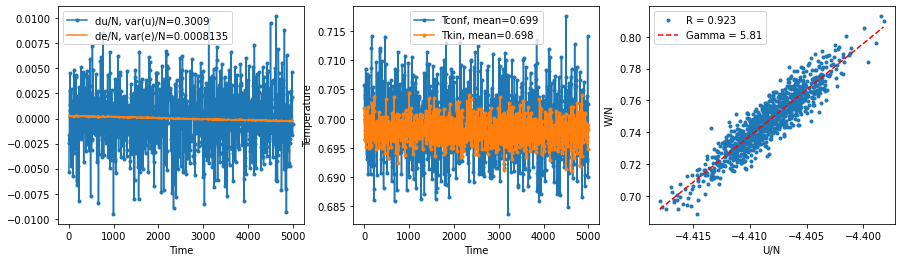

In [22]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=32, pb=128, tp=1, skin=1.0, gridsync=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVE integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVT integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  1525


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 184.203, nbflag:[  0   0 514]
1, 0.200, 343.094, nbflag:[  0   0 293]
2, 0.300, 485.823, nbflag:[  0   0 197]
3, 0.400, 626.688, nbflag:[  0   0 149]
4, 0.500, 744.889, nbflag:[  0   0 119]
5, 0.600, 850.919, nbflag:[ 0  0 98]
6, 0.700, 940.540, nbflag:[ 0  0 83]
7, 0.800, 1031.090, nbflag:[ 0  0 70]
8, 0.900, 1088.248, nbflag:[ 0  0 62]
9, 1.000, 1151.565, nbflag:[ 0  0 55]
10, 1.100, 1179.666, nbflag:[ 0  0 49]
11, 1.200, 1237.414, nbflag:[ 0  0 44]
12, 1.300, 1246.585, nbflag:[ 0  0 39]
13, 1.400, 1259.338, nbflag:[ 0  0 35]
optimal skin: 1.4
	steps : 1000000
	nbflag :  [    0     0 22963]
	time : 1028.8825 s
	time/steps : 1028.8825 us
	TPS :  971.9282814121146
	MATS :  31.848145925312174
	ns/day :  839.7460163702804
	ms/year :  0.3065072959751523



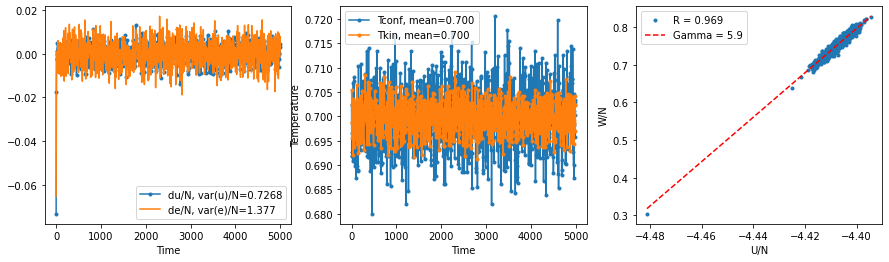

In [23]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=32, pb=128, tp=1, skin=1.0, gridsync=False, UtilizeNIII=True, integrator='NVT')

# Benchmarks

In [24]:

Ns = np.array([512, 1024, 2048, 4096, 8192, 16384, 32768])
TPS_rumd_1080 = np.array([35354, 34226, 31454, 17508, 8824, 6617, 3075])
TPS_rumdpy_3070lap_11 = np.array([80549, 63196, 37959, 17010, 6495, 3441, 872])
TPS_rumdpy_3070lap_12 = np.array([72585, 57683, 37063, 20163, 9180, 3341, 1174])
TPS_rumdpy_3070lap_15 = np.array([80607, 63118, 36931, 20413, 9365, 3365, 1179])
TPS_rumdpy_3070lap_19 = np.array([80789, 63171, 37593, 21635, 9431, 3241, 1165])
TPS_rumdpy_3070lap_25 = np.array([82198, 58611, 34459, 19226, 8300, 3387, 1086])
TPS_rumdpy_3070lap_27 = np.array([81754, 58291, 34427, 18839, 8208, 3462, 1103])
TPS_rumdpy_3070lap_28 = np.array([82215, 60171, 35793, 18839, 8208, 3462, 1103])


print(f'Speed-up: {(TPS_rumdpy_3070lap_27/TPS_rumdpy_3070lap_11)}')

Speed-up: [1.01495984 0.92238433 0.90695224 1.10752499 1.26374134 1.00610288
 1.26490826]


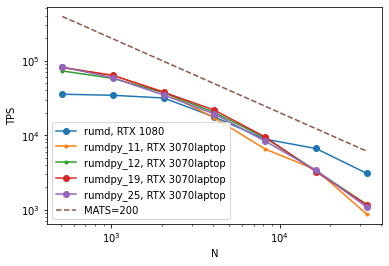

In [25]:
### plt.figure(figsize=(12,8))
plt.loglog(Ns, TPS_rumd_1080, 'o-', label='rumd, RTX 1080')
plt.loglog(Ns, TPS_rumdpy_3070lap_11, '.-', label='rumdpy_11, RTX 3070laptop')
plt.loglog(Ns, TPS_rumdpy_3070lap_12, '.-', label='rumdpy_12, RTX 3070laptop')
plt.loglog(Ns, TPS_rumdpy_3070lap_19, 'o-', label='rumdpy_19, RTX 3070laptop')
plt.loglog(Ns, TPS_rumdpy_3070lap_25, 'o-', label='rumdpy_25, RTX 3070laptop')
plt.loglog(Ns, 200*1e6/Ns, '--', label='MATS=200')
plt.legend()
plt.xlabel('N')
plt.ylabel('TPS')
plt.show()